In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import spectrogram
import tensorflow as tf
import random
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, Normalization, Dropout

import librosa

2024-06-11 13:40:47.410633: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-11 13:40:47.411778: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 13:40:47.468771: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-11 13:40:47.692001: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 13:40:48.434426: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

In [2]:
fileList = {}
emotionClass = {
    "Happy": 0,
    "Angry": 1,
    "Suprised": 2,
    "Sad": 3,
    "Fearful": 4,
    "Neutral": 5,
    "Disgusted": 6,
}
# KAGGLE ===================
# BASE_PATH = '/kaggle/input/audio-emotions/Emotions/'
# for emotion in os.listdir(BASE_PATH):
#     fileList[emotion] = []
#     for file in os.listdir(f"{BASE_PATH}/{emotion}"):
#         fileList[emotion].append(f"{BASE_PATH}{emotion}/{file}")

for emotion in os.listdir("./archive/Emotions"):
    fileList[emotion] = []
    counter = 0
    for file in os.listdir(f"{"./archive/Emotions"}/{emotion}"):
        fileList[emotion].append(f"{"./archive/Emotions/"}{emotion}/{file}")
        counter += 1
        if counter > 40: break

In [ ]:
for k, v in fileList.items():
    print(f"{k:10s} ==> {len(v)}")

# Lee el archivo WAV
sample_rate, data = wavfile.read(fileList["Neutral"][5])

In [3]:
dataRaw = []
max_length = -1
mfcc_number = 13
index = -1
counter = 0

# Calcula el espectrograma
for emotion, filePath in fileList.items():
    for file in filePath:
        # sample_rate, data = wavfile.read(file)

        y, sr   = librosa.load(file)
        mfcc    = librosa.feature.mfcc(y=y, n_mfcc=mfcc_number, sr=sr)
        mfcc = mfcc.T

        # frequencies, times, spectrogram_data = spectrogram(data, fs=sample_rate)
        # spectrogram_data = spectrogram_data.T

        dataRaw.append(
            (
                # spectrogram_data,
                mfcc,
                [emotionClass[emotion]],
            )
        )

        counter += 1

        if np.shape(mfcc)[0] > max_length:
            max_length = np.shape(mfcc)[0]
            index = counter

X = list(list(zip(*dataRaw))[0])
Y = list(list(zip(*dataRaw))[1])
Y = to_categorical(Y, num_classes=7)

for index, element in enumerate(X):
    original_shape = np.shape(element)[0]
    array_zeros = np.zeros((max_length, mfcc_number))
    array_zeros[:original_shape, :] = element
    X[index] = array_zeros

np.concatenate(X, axis=0)
X = np.array(X)
print(X.shape, Y.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

(287, 213, 13) (287, 7)


In [4]:
reshapedTrain = np.zeros((X_train.shape[0], X_train.shape[1],7))
for i in range(0, X_train.shape[0]):
    for j in range(0, X_train.shape[1]):
        reshapedTrain[i][j] = Y_train[i]

Y_train = reshapedTrain

reshapedTest = np.zeros((X_test.shape[0], X_test.shape[1],7))
for i in range(0, X_test.shape[0]):
    for j in range(0, X_test.shape[1]):
        reshapedTest[i][j] = Y_test[i]

Y_test = reshapedTest

In [5]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(215, 213, 13)
(215, 213, 7)
(72, 213, 13)
(72, 213, 7)


In [9]:
X_train_mask = np.zeros((X_train.shape[0], X_train.shape[1]))
X_test_mask = np.zeros((X_test.shape[0], X_test.shape[1]))

In [26]:
X_train_mask = np.all(X_train == 0.0, axis=2)
X_test_mask, np.all(X_test == 0.0, axis=2)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        ...,
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True]]))

In [12]:
# Definir el modelo
model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(None, mfcc_number)))
model.add(Normalization(axis=None))
model.add(LSTM(128, input_shape=(None), mask,return_sequences=True))
model.add(Dropout(0.5))
# model.add(LSTM(128, input_shape=(None), return_sequences=True))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='tanh'))
# model.add(Dense(8, activation='relu'))
# model.add(Dense(8, activation='tanh'))
model.add(Dense(7, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Mostrar resumen del modelo
model.summary()
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=50, batch_size=32, shuffle=False)

# model.fit(X_train, Y_train, epochs=40, batch_size=32, shuffle=True)

/home/aaron/miniconda/envs/audio/lib/python3.12/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, None, 13)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, None, 13)       │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 128)      │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, None, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, None, 32)       │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, None, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, None, 8)        │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, None, 8)        │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, None, 7)        │            63 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,634 (303.26 KB)

 Trainable params: 77,631 (303.25 KB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.1137 - loss: 1.9917 - val_accuracy: 0.1580 - val_loss: 1.9449
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - accuracy: 0.1360 - loss: 1.9486 - val_accuracy: 0.1498 - val_loss: 1.9327
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.1548 - loss: 1.9296 - val_accuracy: 0.1337 - val_loss: 1.9241
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - accuracy: 0.1699 - loss: 1.9229 - val_accuracy: 0.1721 - val_loss: 1.9165
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.1823 - loss: 1.9124 - val_accuracy: 0.1858 - val_loss: 1.9068
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 0.1907 - loss: 1.8997 - val_accuracy: 0.1971 - val_loss: 1.8928
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.1996 - loss: 1.8857 - val_accuracy: 0.2705 - val_loss: 1.8762
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.2232 - loss: 1.8674 - val_accuracy: 0.2886 - val_loss: 

In [34]:
print(history)

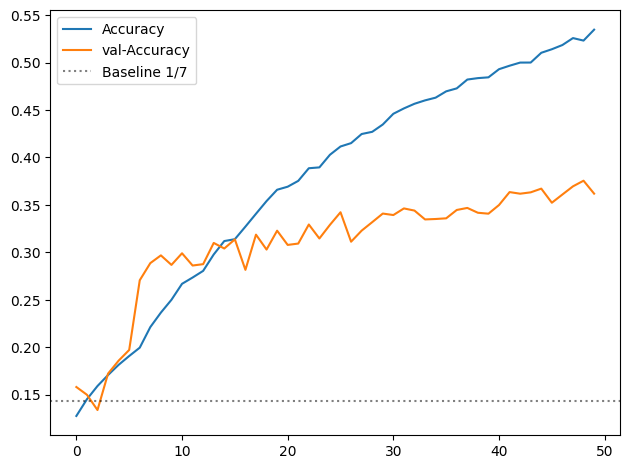

In [13]:

plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='val-Accuracy')
plt.axhline(1/7, c='black', alpha=0.5, linestyle='dotted', label='Baseline 1/{}'.format(7))
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
a = X_train[0]
print(type(a))
prediction = model.predict(X_train[30:31])

<class 'numpy.ndarray'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [159]:
prediction[0][:, 0].shape

(213,)

In [78]:
import matplotlib
import matplotlib.pyplot as plt


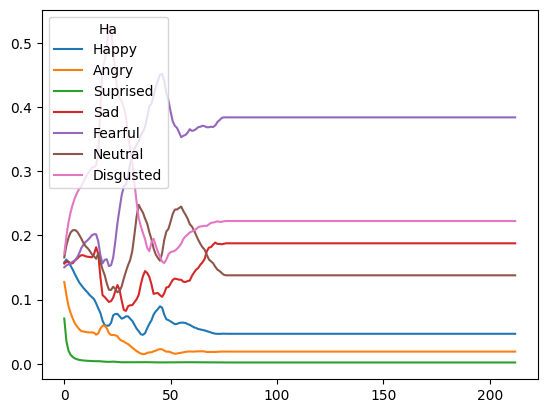

In [18]:
plt.plot(prediction[0][:, 0], label=list(emotionClass.keys())[list(emotionClass.values()).index(0)])
plt.plot(prediction[0][:, 1], label=list(emotionClass.keys())[list(emotionClass.values()).index(1)])
plt.plot(prediction[0][:, 2], label=list(emotionClass.keys())[list(emotionClass.values()).index(2)])
plt.plot(prediction[0][:, 3], label=list(emotionClass.keys())[list(emotionClass.values()).index(3)])
plt.plot(prediction[0][:, 4], label=list(emotionClass.keys())[list(emotionClass.values()).index(4)])
plt.plot(prediction[0][:, 5], label=list(emotionClass.keys())[list(emotionClass.values()).index(5)])
plt.plot(prediction[0][:, 6], label=list(emotionClass.keys())[list(emotionClass.values()).index(6)])

plt.legend(title="Ha")
plt.show()